**<a href="https://www.kaggle.com/competitions/journey-springfield/overview/">Классификация симпсонов</a>**

# Задание

В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде, из вселенной мультсериала "Симпсоны".

**Материалы к проекту (файлы):**
* папка [train](https://www.kaggle.com/competitions/journey-springfield/data?select=train)- содержит папки, названия которых соответствуют персонажу и соответственно являются лейблом,
* папка [testset](https://www.kaggle.com/competitions/journey-springfield/data?select=testset) - содержит изображения персонажей, которые нужно классифицировать,
* [sample_submission.csv](https://www.kaggle.com/competitions/journey-springfield/data?select=sample_submission.csv)

**Основная метрика:**
F1-Score (sklearn.metrics.f1_score)

Метрикой в этом соревновании является "Mean F1-Score". F1-мера вычисляется на основе точности P (Precission) и полноты (Recall) R. Точность - это отношение True positives (TP**) ко всем Predicted positives (TP, FP). Полнота - отношение True positives ко всем Actual positives (TP + FN).

$$F1 = 2 \frac{P \cdot R}{P + R}, \,\, P = \frac{TP}{TP + FP}, \,\, R = \frac{TP}{TP + FN}$$

# Установка зависимостей

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torchvision.transforms as tfs
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# Режимы датасета
DATA_MODES = ['train', 'valid', 'test']
# Масштабирование изображений 224x224 px
RESCALE_SIZE = 224
# Выбор процессора
train_on_gpu = torch.cuda.is_available()
DEVICE = torch.device("cpu")
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    DEVICE = torch.device("cuda")
    print('CUDA is available!  Training on GPU ...')
    print()
    !nvidia-smi

# Пути
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')
SUBMIT_SAMPLE_PATH = "./sample_submission.csv"
SUBMIT_NAME = "submit_simple_cnn_107092664.csv"
# Количество эпох
EPOCHS=12
# Размер батча
BATCH_SIZE=128

CUDA is available!  Training on GPU ...

Fri Apr 19 22:00:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0  On |                  N/A |
| 52%   45C    P8    19W / 125W |    496MiB /  6144MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

# Загрузка данных

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# !unzip -q "/content/drive/MyDrive/dls/data/07/journey-springfield.zip"

In [ ]:
# !ls train

# 1.&nbsp;Анализ и обработка данных

In [ ]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
len(train_files), len(test_files)

(20933, 991)

### Распределение файлов в тренировочном датасете

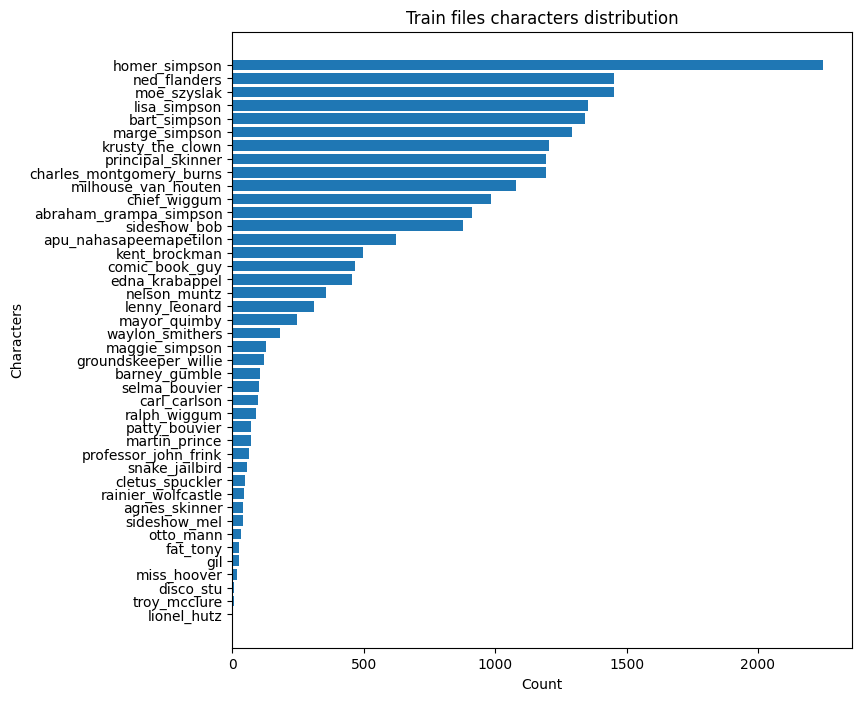

In [ ]:
train_labels = [path.parent.name for path in train_files]

counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8, 8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

### Соответствие изображений классам в тренировочном датасете

Некоторые изображения не соответствуют своим классам (папкам).

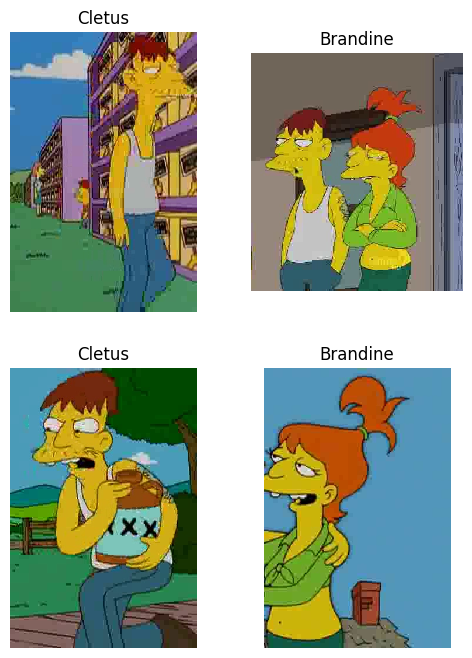

In [ ]:
cletus_dir = str(TRAIN_DIR) + "/simpsons_dataset/cletus_spuckler/"
cletus_labels = ['Cletus', 'Brandine', 'Cletus', 'Brandine']
cletus_paths = ['pic_0000.jpg', 'pic_0014.jpg', 'pic_0003.jpg', 'pic_0046.jpg']
fig, axs = plt.subplots(2, 2, figsize=(6, 8))

for ax, i in zip(axs.ravel(), list(range(4))):
    img = mpimg.imread(cletus_dir + cletus_paths[i])
    ax.imshow(img, interpolation='none')
    ax.set_title(cletus_labels[i])
    ax.axis('off')

plt.axis('off')
plt.show()

- В тестовых данных 991 картинка.
- В тренировочных данных количество изображений по классам распределено неравномерно.
- В классах есть некорректные изображения
- Изображения имеют разный размер (ширина X высота)

### Обработка данных

Создадим обертку для работы с данными и переопределим функцию `__getitem()__`.

 - ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0, 1] , затем производится масштабирование:
$$input = \frac{input - \mu}{\text{standard deviation}},$$ где константы - средние и дисперсии по каналам на основе *ImageNet*.

- Масштабирование к размеру 224x224 px.
- Различные аугментации: Crop, Rotation, Flip

 Также используем LabelEncoder для преобразования строковых меток классов в Id и обратно.

 <a href="https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/">Преобразования baseline</a>
 <a href=" https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py">Преобразования pytoch</a>

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'test' or self.mode == 'valid':
            transform = tfs.Compose([
                tfs.Resize(size=(RESCALE_SIZE, RESCALE_SIZE), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentation = tfs.RandomChoice([
                tfs.Compose([
                    tfs.Resize(size=300, max_size=301),
                    tfs.CenterCrop(size=325),
                    tfs.RandomCrop(300)
                ]),
                tfs.RandomRotation(degrees=(-25, 25)),
                tfs.RandomHorizontalFlip()
            ])
            transform = tfs.Compose([
                augmentation,
                tfs.Resize(size=(RESCALE_SIZE, RESCALE_SIZE), antialias=True),
                tfs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                tfs.ToTensor(),
                tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

**Обработка некорректных данных**

In [ ]:
len(train_files)

20933

In [ ]:
common_path = str(TRAIN_DIR) + "/simpsons_dataset/"
incorrect_imgs_list = ["abraham_grampa_simpson/pic_0029.jpg",
                       "agnes_skinner/pic_0029.jpg",
                       "apu_nahasapeemapetilon/pic_0617.jpg",
                       "apu_nahasapeemapetilon/pic_0505.jpg",
                       "apu_nahasapeemapetilon/pic_0507.jpg",
                       "bart_simpson/pic_1322.jpg",
                       "bart_simpson/pic_1323.jpg",
                       "bart_simpson/pic_1324.jpg",
                       "charles_montgomery_burns/pic_0551.jpg",
                       "cletus_spuckler/pic_0046.jpg",
                       "cletus_spuckler/pic_0022.jpg",
                       "groundskeeper_willie/pic_0007.jpg",
                       "krusty_the_clown/pic_0228.jpg",
                       "ned_flanders/pic_0039.jpg",
                       "sideshow_mel/pic_0032.jpg",
                       "sideshow_mel/pic_0034.jpg"]
incorrect_imgs_list = list([common_path + ii for ii in incorrect_imgs_list])
len(incorrect_imgs_list)

16

In [ ]:
train_files = list([tf for tf in train_files if str(tf) not in incorrect_imgs_list])
train_labels = [path.parent.name for path in train_files]

In [ ]:
len(train_files)

20933

**Сплит**

In [ ]:
train_files_split, val_files_split = train_test_split(train_files, test_size=0.25, \
                                          stratify=train_labels, random_state=42)

In [ ]:
train_dataset = SimpsonsDataset(train_files_split, mode='train')
valid_dataset = SimpsonsDataset(val_files_split, mode='valid')

**Балансирование тренировочных данных**

Попробуем сбалансировать тренировочные данные c помощью WeightedRandomSampler

In [ ]:
train_labels_split = [path.parent.name for path in train_files_split]

counts_split = pd.Series(train_labels_split).value_counts()

In [ ]:
def create_wr_sampler(train_dataset, train_files, value_counts):
    count_weights = {k: 1/v for k, v in value_counts.items()}
    sample_weights = len(train_files) * [0]

    for i, (data, label) in enumerate(tqdm(train_dataset)):
        label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
        sample_weights[i] = label_weight

    N = value_counts.max() * len(count_weights)
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=int(N), replacement=True)

    return train_sampler

In [ ]:
wr_sampler = create_wr_sampler(train_dataset=train_dataset,
                                     train_files=train_files_split,
                                     value_counts=counts_split)

100%|███████████████████████████████████████████████████████████████████████████| 15699/15699 [01:00<00:00, 259.71it/s]


**Визуализация**

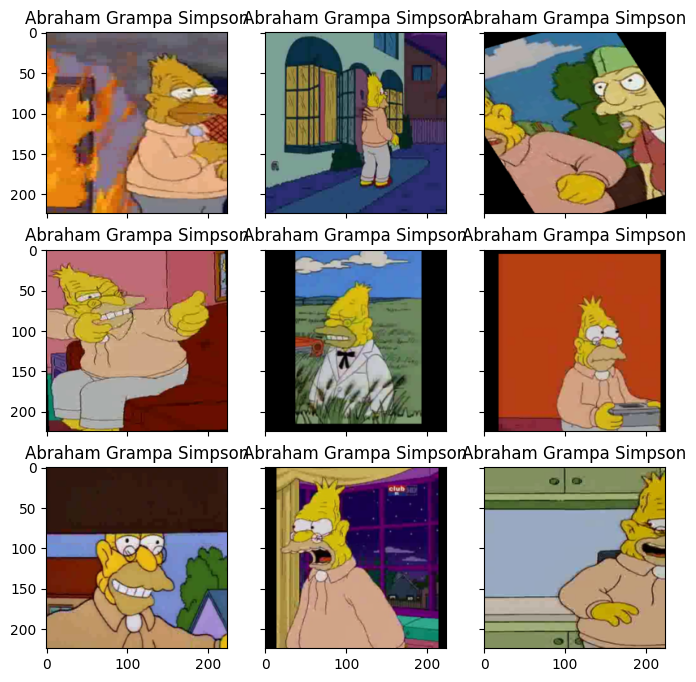

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valid_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# 2.&nbsp;Построение нейросети

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=2400),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=2400),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=42)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

*Описание слоев:*

In [ ]:
n_classes = len(np.unique(train_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("We will classify :{}".format(n_classes))
print(simple_cnn)

We will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_f

# 3.&nbsp;Обучение нейросети

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_ds, val_ds, model, epochs, batch_size, train_sampler):
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)

            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Запустим обучение сети.

In [ ]:
history = train(train_dataset, valid_dataset, model=simple_cnn, epochs=EPOCHS,
                batch_size=BATCH_SIZE, train_sampler=wr_sampler)

epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

loss 1.6033335782367575


epoch:   8%|██████                                                                   | 1/12 [05:53<1:04:51, 353.76s/it]


Epoch 001 train_loss: 1.6033     val_loss 1.4085 train_acc 0.5655 val_acc 0.6251
loss 0.3601696545243627


epoch:  17%|████████████▌                                                              | 2/12 [11:48<59:06, 354.62s/it]


Epoch 002 train_loss: 0.3602     val_loss 1.0150 train_acc 0.8969 val_acc 0.7423
loss 0.19187930511168907


epoch:  25%|██████████████████▊                                                        | 3/12 [17:37<52:46, 351.85s/it]


Epoch 003 train_loss: 0.1919     val_loss 0.9305 train_acc 0.9440 val_acc 0.7824
loss 0.1306153457983022


epoch:  33%|█████████████████████████                                                  | 4/12 [23:37<47:21, 355.14s/it]


Epoch 004 train_loss: 0.1306     val_loss 0.9495 train_acc 0.9605 val_acc 0.7944
loss 0.10063409700504311


epoch:  42%|███████████████████████████████▎                                           | 5/12 [29:31<41:21, 354.55s/it]


Epoch 005 train_loss: 0.1006     val_loss 0.9495 train_acc 0.9707 val_acc 0.8118
loss 0.04704878387890336


epoch:  50%|█████████████████████████████████████▌                                     | 6/12 [35:05<34:46, 347.75s/it]


Epoch 006 train_loss: 0.0470     val_loss 0.8505 train_acc 0.9861 val_acc 0.8389
loss 0.030503391670504518


epoch:  58%|███████████████████████████████████████████▊                               | 7/12 [40:43<28:42, 344.54s/it]


Epoch 007 train_loss: 0.0305     val_loss 0.8888 train_acc 0.9913 val_acc 0.8405
loss 0.02270417676307577


epoch:  67%|██████████████████████████████████████████████████                         | 8/12 [46:20<22:48, 342.08s/it]


Epoch 008 train_loss: 0.0227     val_loss 0.9241 train_acc 0.9939 val_acc 0.8418
loss 0.016828895581679913


epoch:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [51:58<17:02, 340.68s/it]


Epoch 009 train_loss: 0.0168     val_loss 0.9726 train_acc 0.9954 val_acc 0.8433
loss 0.014910169862074439


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 10/12 [57:36<11:20, 340.10s/it]


Epoch 010 train_loss: 0.0149     val_loss 1.0178 train_acc 0.9957 val_acc 0.8447
loss 0.013436620020212899


epoch:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [1:03:15<05:39, 339.56s/it]


Epoch 011 train_loss: 0.0134     val_loss 1.0119 train_acc 0.9965 val_acc 0.8449
loss 0.013971919189439533


epoch: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [1:08:51<00:00, 344.26s/it]


Epoch 012 train_loss: 0.0140     val_loss 1.0120 train_acc 0.9962 val_acc 0.8458


Сохраним веса

In [ ]:
torch.save(simple_cnn.state_dict(), "weights_simple.pt")

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

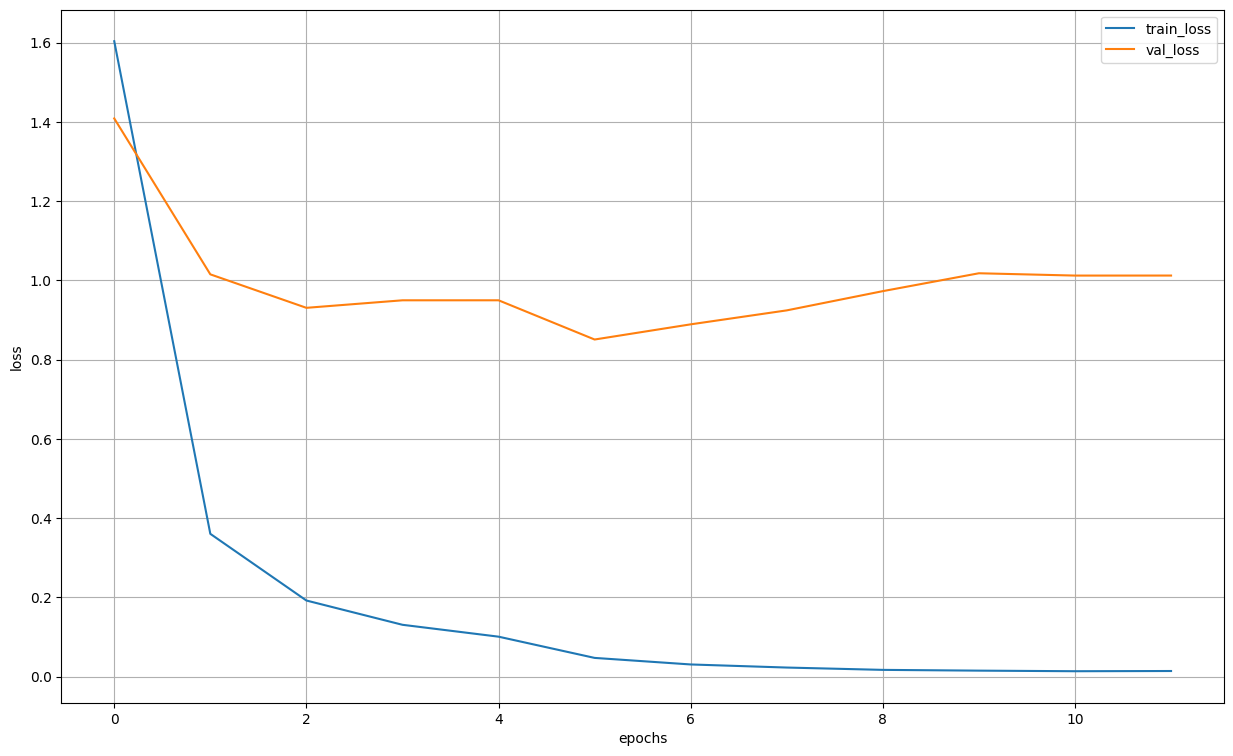

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

# 4.&nbsp;Оценка

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = valid_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [valid_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [valid_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.75


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

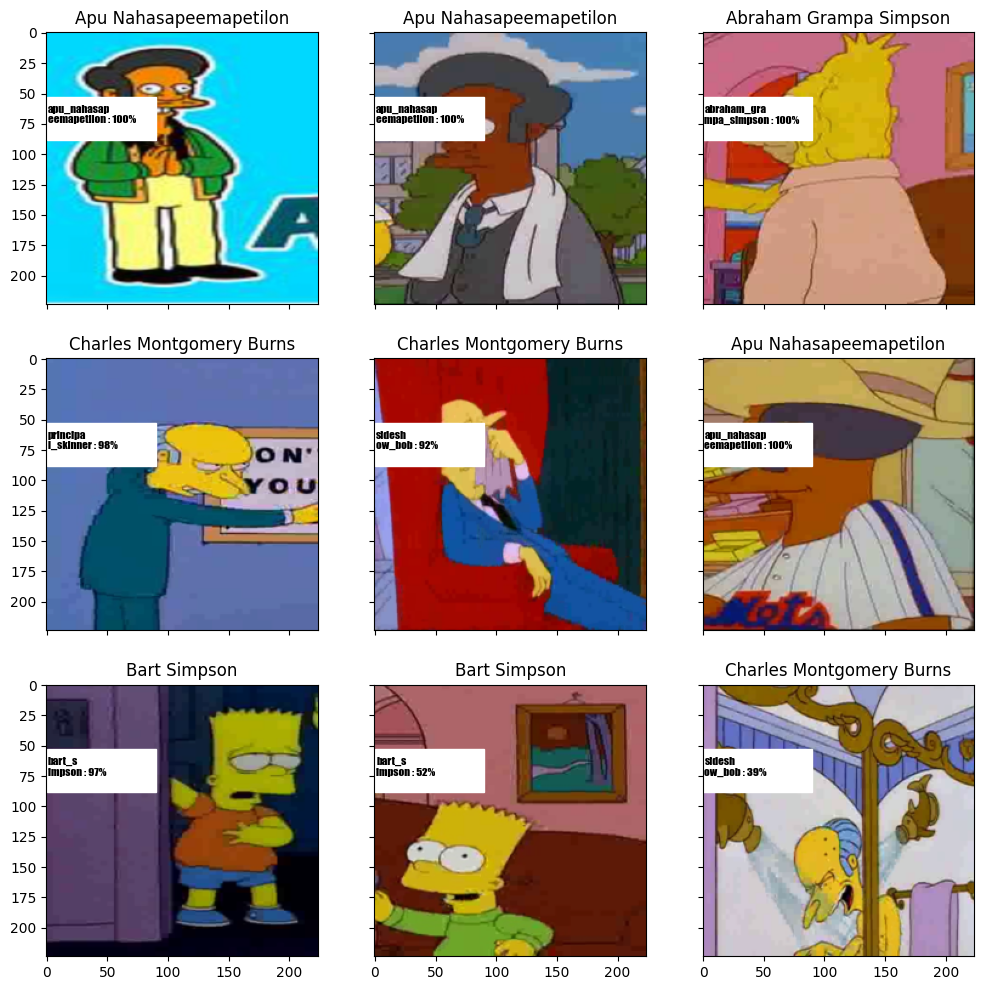

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = valid_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                valid_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 90, 35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

# 5.&nbsp;Классифиция  на тестовых данных. Submit.

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submit.shape

(991, 2)

In [ ]:
submit.to_csv(SUBMIT_NAME, index=False)

---